In [324]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [325]:
# Check GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [326]:
!pip install torch

In [327]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [328]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/BDI Monthly Price.csv')
len(df)

240

In [329]:
df.head()

,Date,Price
0,10/1/2000,1759
1,11/1/2000,1672
2,12/1/2000,1599
3,6/1/2000,1616
4,7/1/2000,1642


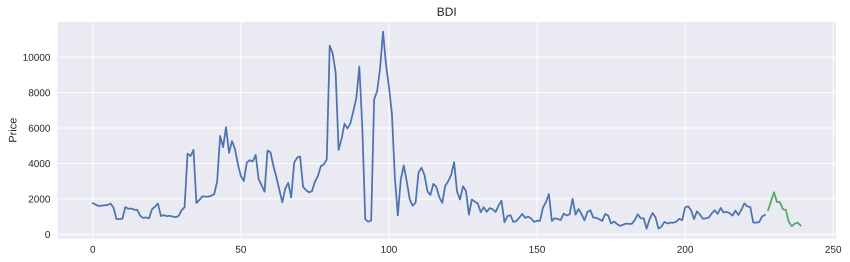

In [330]:
plt.figure(dpi=105,figsize=(14,4))
df["Price"].iloc[:228].plot(legend=False)
df["Price"].iloc[-12:].plot(legend=False)
plt.title('BDI')
plt.ylabel("Price")
plt.show()

In [331]:
df = df['Price'].values.astype(float)

In [332]:
test_data_size = 12

train_data = df[:-test_data_size]
test_data = df[-test_data_size:]

In [333]:
print(len(train_data))
print(len(test_data))

228
12


In [334]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [335]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.74071743]
 [-0.75636069]
 [-0.76948665]
 [-0.76642992]
 [-0.76175492]]
[[-0.93688753]
 [-0.93868561]
 [-0.93311157]
 [-0.87521352]
 [-0.85992988]]


In [336]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [337]:
train_window = 12

In [338]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [339]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [340]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [341]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [342]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00000116
epoch:  26 loss: 0.00014676
epoch:  51 loss: 0.00010335
epoch:  76 loss: 0.00015159
epoch: 101 loss: 0.00017261
epoch: 126 loss: 0.00041529
epoch: 149 loss: 0.0000115035


In [343]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.8673020005226135, -0.8158770203590393, -0.8610087037086487, -0.8079654574394226, -0.7428750991821289, -0.7730827927589417, -0.7800952792167664, -0.9368875026702881, -0.9386855959892273, -0.9331115484237671, -0.8752135038375854, -0.8599298596382141]


In [344]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [345]:
test_inputs[fut_pred:]

[-0.8314435482025146,
 -0.8064142465591431,
 -0.7868847846984863,
 -0.7748129367828369,
 -0.7699549198150635,
 -0.7784066796302795,
 -0.7966850996017456,
 -0.8127885460853577,
 -0.8237344026565552,
 -0.8292227983474731,
 -0.8291782736778259,
 -0.8245373964309692]

In [346]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[1254.42670667]
 [1393.62716776]
 [1502.2402699 ]
 [1569.37785208]
 [1596.39571345]
 [1549.39125124]
 [1447.73581856]
 [1358.17650095]
 [1297.30111963]
 [1266.77740699]
 [1267.02503094]
 [1292.83526975]]


In [347]:
x = np.arange(228, 240, 1)
print(x)

[228 229 230 231 232 233 234 235 236 237 238 239]


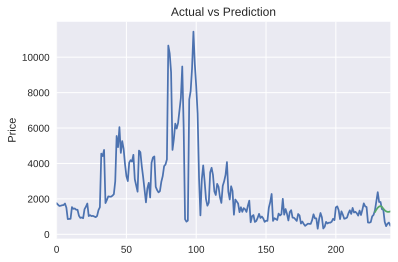

In [348]:
plt.title('Actual vs Prediction')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df)
plt.plot(x,actual_predictions)
plt.show()

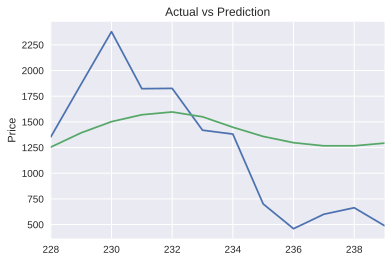

In [349]:
plt.title('Actual vs Prediction')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(x, df[-12:])
plt.plot(x,actual_predictions)
plt.show()

In [350]:
from sklearn.metrics import mean_squared_error
rms_error = np.sqrt(mean_squared_error(df[-12:],actual_predictions))
print("RMS Error is ",rms_error)

RMS Error is  557.2552828063557
